In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchtext #conda install torchtext -c pytorch
from torchtext.data import get_tokenizer

import numpy as np 
SEED = 10

/home/azyen/anaconda3/envs/litorch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  # cuda algorithms
os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
text = 'This is a pytorch tutorial for tokenization! U.S.A.'

In [4]:
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(text)

print(tokens)

['this', 'is', 'a', 'pytorch', 'tutorial', 'for', 'tokenization', '!', 'u', '.', 's', '.', 'a', '.']


In [5]:
tokenizer = get_tokenizer('spacy')
# pip install spacy
# python -m spacy download en_core_web_sm

tokens = tokenizer(text)

print(type(tokens))
print(tokens)

/home/azyen/anaconda3/envs/litorch/lib/python3.8/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


<class 'list'>
['This', 'is', 'a', 'pytorch', 'tutorial', 'for', 'tokenization', '!', 'U.S.A.']


In [6]:
# python -m spacy download zh_core_web_sm
# You can now load the package via spacy.load('zh_core_web_sm')

import spacy

nlp = spacy.load('zh_core_web_sm')

zh_text = '醒醒吧！你沒有妹妹！'

zh_tokenizer = get_tokenizer(nlp)
zh_tokens = zh_tokenizer(zh_text)

print(type(zh_tokens))

<class 'spacy.tokens.doc.Doc'>


In [7]:
result = [token.text for token in zh_tokens]
print(result)

['醒醒', '吧', '！', '你', '沒有', '妹妹', '！']


Load GloVe '6B' Embeddings

In [8]:
trained_vectors = torchtext.vocab.Vectors('/nfs/nas-6.1/azyen/backup/Data/glove.6B.50d.txt')

In [9]:
embeddings = trained_vectors.get_vecs_by_tokens(tokenizer("Hello, How are you?"), lower_case_backup=True)

embeddings.shape

torch.Size([6, 50])

In [10]:
embeddings

tensor([[-3.8497e-01,  8.0092e-01,  6.4106e-02, -2.8355e-01, -2.6759e-02,
         -3.4532e-01, -6.4253e-01, -1.1729e-01, -3.3257e-01,  5.5243e-01,
         -8.7813e-02,  9.0350e-01,  4.7102e-01,  5.6657e-01,  6.9850e-01,
         -3.5229e-01, -8.6542e-01,  9.0573e-01,  3.5760e-02, -7.1705e-02,
         -1.2327e-01,  5.4923e-01,  4.7005e-01,  3.5572e-01,  1.2611e+00,
         -6.7581e-01, -9.4983e-01,  6.8666e-01,  3.8710e-01, -1.3492e+00,
          6.3512e-01,  4.6416e-01, -4.8814e-01,  8.3827e-01, -9.2460e-01,
         -3.3722e-01,  5.3741e-01, -1.0616e+00, -8.1403e-02, -6.7111e-01,
          3.0923e-01, -3.9230e-01, -5.5002e-01, -6.8827e-01,  5.8049e-01,
         -1.1626e-01,  1.3139e-02, -5.7654e-01,  4.8833e-02,  6.7204e-01],
        [ 1.3441e-02,  2.3682e-01, -1.6899e-01,  4.0951e-01,  6.3812e-01,
          4.7709e-01, -4.2852e-01, -5.5641e-01, -3.6400e-01, -2.3938e-01,
          1.3001e-01, -6.3734e-02, -3.9575e-01, -4.8162e-01,  2.3291e-01,
          9.0201e-02, -1.3324e-01,  7

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self,index):
        return self.data[index],self.label[index]

    def __len__(self):
        return len(self.data)

In [13]:
def set_label(star):
    if star > 3:
        y = 2 # positive
    elif star < 3:
        y = 0 # negative
    else:
        y = 1 # neutral
    return y

ys = [0,0,0]
ct = -1
with open('/nfs/nas-4.1/azyen/w2v_project/c_test_1_stars.txt', encoding='utf-8',  errors='ignore') as f:
    for l in f:
        ct += 1
        if ct == 10000:
            break
        if ct < 9000:
            continue
        star = float(l.split('\t')[0])
        y = set_label(star)
        ys[y] += 1
        

print(ys)

[187, 147, 666]


In [14]:
ys[2]/sum(ys)

0.666

In [15]:
embed_len = 50
batch_size = 64
num_labels = 3

def vectorize(star, text_arr):
    x_tensor = torch.zeros(embed_len)
    for i, token in enumerate(text_arr):
        x_tensor = torch.add(x_tensor, trained_vectors.get_vecs_by_tokens(token.lower()))
    if star > 3:
        y = 2 # positive
    elif star < 3:
        y = 0 # negative
    else:
        y = 1 # neutral
    #print(star, label)
    return x_tensor, y

target_classes = ["negative", "neutral", "positive"]

X, Y = [], []
ct = 0
with open('/nfs/nas-4.1/azyen/w2v_project/c_test_1_stars.txt', encoding='utf-8',  errors='ignore') as f:
    for l in f:
        if ct == 10000:
            break
        star, review = float(l.split('\t')[0]), tokenizer(l.split('\t')[1])
        x_tensor, y = vectorize(star, review)
        X.append(x_tensor)
        Y.append(y)
        ct += 1
        

X = torch.stack(X)
Y = torch.LongTensor(Y)

In [16]:
type(Y)

torch.Tensor

In [17]:
print(X.shape)
print(Y.shape)

torch.Size([10000, 50])
torch.Size([10000])


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


train_data = MyDataset(X[:8000], Y[:8000])
valid_data = MyDataset(X[8000:9000], Y[8000:9000])
test_data = MyDataset(X[9000:], Y[9000:])

train_sampler = RandomSampler(train_data)
valid_sampler = SequentialSampler(valid_data)
test_sampler = SequentialSampler(test_data)


train_loader = DataLoader(dataset=train_data, sampler=train_sampler, batch_size=64)
valid_loader = DataLoader(dataset=test_data, sampler=valid_sampler, batch_size=64)
test_loader = DataLoader(dataset=test_data, sampler=test_sampler, batch_size=64)


In [19]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([64, 50]) torch.Size([64])


In [20]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(embed_len, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, num_labels)
        )

    def forward(self, x):
        logits = self.dnn(x)
        return logits

model = NeuralNetwork().to(device) # move it to the GPU
print(model)

Using cuda device
NeuralNetwork(
  (dnn): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        #print(pred.shape)
        #print(y.shape)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 10.404387  [    0/ 8000]
loss: 1.128973  [ 6400/ 8000]
Test Error: 
 Accuracy: 76.1%, Avg loss: 0.685310 

Epoch 2
-------------------------------
loss: 0.403199  [    0/ 8000]
loss: 0.991083  [ 6400/ 8000]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.615813 

Epoch 3
-------------------------------
loss: 0.346081  [    0/ 8000]
loss: 0.561870  [ 6400/ 8000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.606264 

Epoch 4
-------------------------------
loss: 0.445688  [    0/ 8000]
loss: 0.451673  [ 6400/ 8000]
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.665263 

Epoch 5
-------------------------------
loss: 0.494467  [    0/ 8000]
loss: 0.617141  [ 6400/ 8000]
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.658309 

Epoch 6
-------------------------------
loss: 0.549413  [    0/ 8000]
loss: 0.410863  [ 6400/ 8000]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.588201 

Epoch 7
-------------------------------
loss: 0.651016  [    0/ 8000]
loss: 0.481436  [

In [25]:
torch.save(model.state_dict(), "hotel_review.model")

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = NeuralNetwork()
model.to(device)
model.load_state_dict(torch.load("hotel_review.model"))

<All keys matched successfully>

In [27]:
model.eval()

y_pred, y_true = [], []

with torch.no_grad(): # https://pytorch.org/docs/stable/generated/torch.no_grad.html
    for x, y in test_data:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        #print(pred)
        predicted, actual = target_classes[pred.argmax(0)], target_classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        y_pred.append(predicted); y_true.append(actual)

Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "negative", Actual: "negative"
Predicted: "negative", Actual: "negative"
Predicted: "negative", Actual: "negative"
Predicted: "positive", Actual: "neutral"
Predicted: "positive", Actual: "negative"
Predicted: "negative", Actual: "neutral"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "negative", Actual: "negative"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "positive"
Predicted: "positive", Actual: "posi

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.779

In [29]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred, labels=target_classes)
cf_matrix

array([[135,   5,  47],
       [ 37,   2, 108],
       [ 21,   3, 642]])

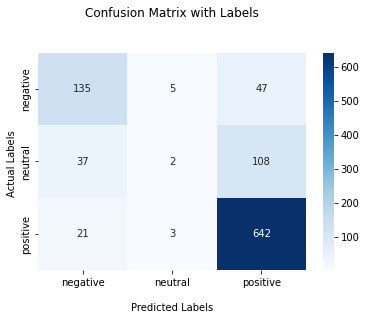

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix with Labels\n\n');
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(target_classes)
ax.yaxis.set_ticklabels(target_classes)

## Display the visualization of the Confusion Matrix.
plt.show()